In [79]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE
import requests
import matplotlib.cm as cm



In [80]:
# Dynamic stock data fetched from wikipedia list of S&P 500 companies

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    html = requests.get(url).content
    df_list = pd.read_html(html)
    
    # The relevant table containing S&P 500 information is typically the first one
    sp500_table = df_list[0]
    
    # Extracting the columns of interest
    sp500_data = sp500_table[['Symbol', 'Security']]
    
    return sp500_data

# Call the function to get the S&P 500 data
sp500_data = get_sp500_tickers()
companies_dict = sp500_data.set_index('Symbol').to_dict()['Security']

# Display the data
print(len(companies_dict))
tickers = list(companies_dict.keys())



503


In [81]:
# Reading data from the given csv file

data = pd.read_csv('SP500_prices.csv')

In [82]:
# Data cleaning - removing columns with company names not in S&P 500

for c in data.columns[1:]:
    if c not in tickers:
        data = data.drop([c], axis=1)

# Data cleaning - datatype conversion and date filtering

data.date = pd.to_datetime(data.date)
data = data[data.date > "2018"][data.date < "2022"]
data.index = data["date"]
data.drop(columns=["date"],inplace=True)        

In [83]:
data.head()

,A,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.305023,51.647560,41.075401,79.550964,54.646271,144.274887,177.699997,82.765312,35.165939,105.598396,...,154.734451,42.066658,66.545746,64.630898,64.491646,75.387535,116.359734,103.709999,44.894779,69.868118
2018-01-03,66.966637,51.014027,41.068260,80.795830,54.767101,144.940720,181.039993,83.792084,34.894012,106.745522,...,153.058075,41.785095,67.852715,64.409477,65.278023,75.322861,117.166344,105.769997,44.841648,70.189369
2018-01-04,66.464294,51.335659,41.259010,80.335068,54.674156,146.656967,183.220001,83.700409,35.481724,107.765190,...,153.886810,41.459538,67.946640,64.399857,65.713814,76.089676,116.997498,107.860001,45.027615,70.607986
2018-01-05,67.526939,51.316170,41.728756,81.733505,54.832184,147.866745,185.339996,84.039627,35.244881,107.701454,...,154.913391,41.169186,67.891838,65.304726,65.590652,76.533119,118.160545,109.540001,45.045311,71.415993
2018-01-08,67.671867,50.809345,41.573761,80.423965,54.674156,149.048401,185.039993,84.186310,35.165939,107.373703,...,152.850906,41.477135,68.197075,65.747551,65.827507,76.662468,118.385658,110.629997,44.823944,72.272667


In [84]:
returns_1_day = data.pct_change()
# returns_2_day = data.pct_change(2)
# returns_5_day = data.pct_change(5)
# returns_10_day = data.pct_change(10)
# returns_20_day = data.pct_change(20)
# returns_60_day = data.pct_change(60)
# returns_252_day = data.pct_change(252)



# Removing the first row of NaN values due to pct_change function

returns_1_day = returns_1_day.iloc[1:,:]





# list_of_returns = [returns_1_day,returns_2_day,returns_5_day,returns_10_day,returns_20_day,returns_60_day,returns_252_day]

In [85]:
# we can only work with stocks that have the full return series

# for returns in list_of_returns:
#     returns.dropna(axis=1,inplace=True)
#     returns = returns_1_day.iloc[1:,:]

# list_of_returns

In [86]:
# Checking for NaN values

# Check for missing values in returns_1_day
missing_values = returns_1_day.isnull().sum()

# Display columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]
print("Columns with Missing Values:")
print(columns_with_missing_values)

# Display total number of missing values in each column
print("\nTotal Number of Missing Values in Each Column:")
print(missing_values)

# Print missing vlues in csv file

# missing_values.to_csv('missing.csv')



# As we can see, there are columns with missing values, we will drop them

returns_1_day.dropna(axis=1,inplace=True)


Columns with Missing Values:
CARR     556
CDAY      79
CEG     1007
CTVA     350
DOW      304
FOX      299
FOXA     298
MRNA     235
OTIS     556
dtype: int64

Total Number of Missing Values in Each Column:
A       0
AAL     0
AAPL    0
ABBV    0
ABT     0
       ..
YUM     0
ZBH     0
ZBRA    0
ZION    0
ZTS     0
Length: 473, dtype: int64


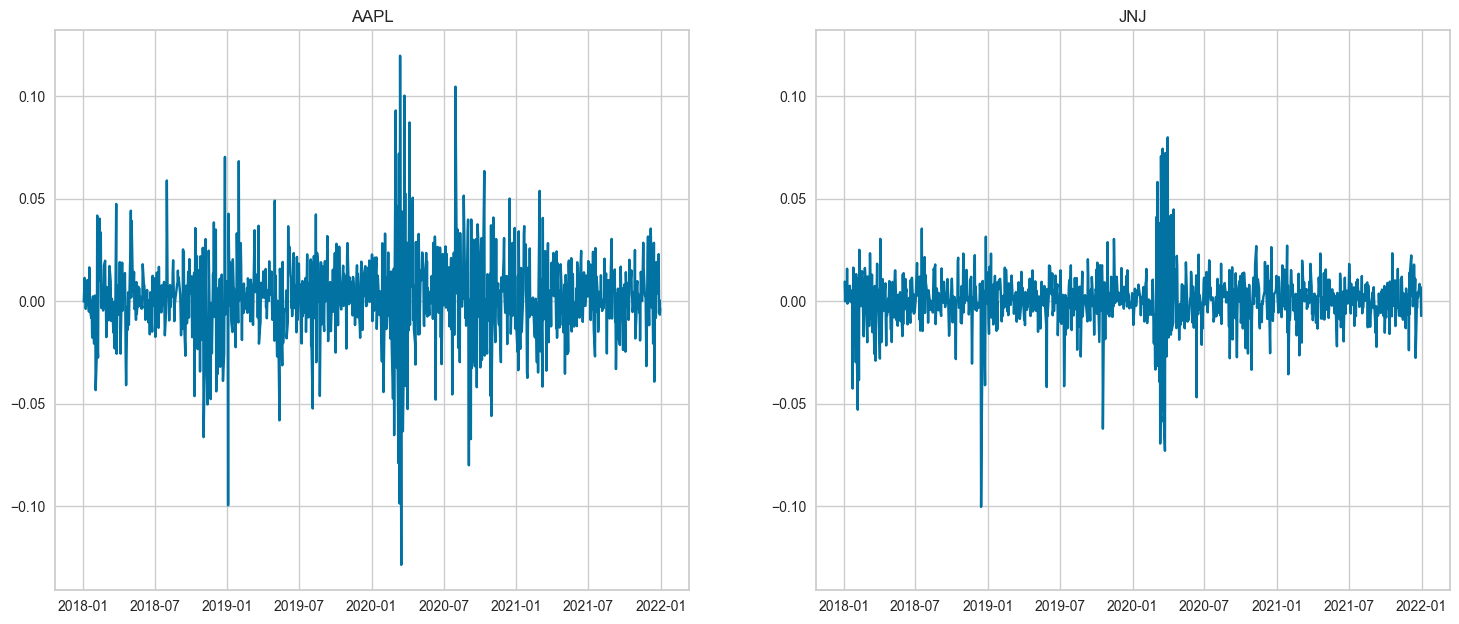

In [87]:
# Compare the movement of different stocks. 

plt.figure(figsize=(18,16))
ax1 = plt.subplot(221)
plt.plot(returns_1_day["AAPL"])
plt.title("AAPL")

plt.subplot(222, sharey=ax1)
plt.plot(returns_1_day["JNJ"])
plt.title("JNJ")
plt.show()

In [88]:
ret_T = returns_1_day.T

ret_T = pd.DataFrame(ret_T)
# ret_T.index = ret_T["Stock"]
ret_T.index.name = 'stock'
ret_T
# ret_T.rename(columns={"index":"Stock"},inplace=True)

date,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,...,2021-12-17,2021-12-20,2021-12-21,2021-12-22,2021-12-23,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
stock,,,,,,,,,,,,,,,,,,,,,
A,0.025444,-0.007501,0.015988,0.002146,0.024554,-0.013655,0.000141,0.013136,-0.006971,0.011653,...,0.004111,-0.006604,0.023534,0.018317,0.006506,0.005957,0.002772,0.009235,0.001432,-0.007646
AAL,-0.012266,0.006305,-0.000380,-0.009877,-0.000959,0.032642,0.049089,0.036335,-0.008380,0.003105,...,0.026029,0.020649,0.047399,0.007726,0.000000,-0.004929,0.020363,-0.026429,0.001108,-0.006087
AAPL,-0.000174,0.004645,0.011385,-0.003714,-0.000114,-0.000230,0.005680,0.010326,-0.005082,0.016516,...,-0.006502,-0.008122,0.019087,0.015319,0.003644,0.022975,-0.005767,0.000502,-0.006578,-0.003535
ABBV,0.015649,-0.005703,0.017408,-0.016022,0.007539,-0.005487,0.002930,0.010779,0.021427,0.018246,...,-0.017074,0.010268,-0.006954,0.016160,0.007876,0.009918,-0.000149,0.007218,0.004211,-0.003899
ABT,0.002211,-0.001697,0.002890,-0.002882,0.001700,-0.001527,0.006832,-0.001866,-0.006798,0.009411,...,0.007495,-0.015535,0.002149,0.027500,0.001223,0.016528,-0.006998,0.005125,-0.001346,-0.001844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,-0.000858,0.010180,0.005828,0.001690,-0.002651,-0.002537,-0.000727,0.013699,-0.008252,0.001929,...,-0.012426,-0.002729,0.013681,0.009447,0.005274,0.019728,-0.000217,0.004928,-0.001947,0.003396
ZBH,0.006932,-0.001441,0.009941,0.001905,-0.016083,-0.013367,-0.001959,-0.001554,-0.003440,0.006657,...,0.003154,-0.016218,0.030028,0.018537,0.018119,0.008363,0.003130,0.000156,0.000312,-0.009589
ZBRA,0.019863,0.019760,0.015576,0.009951,0.030643,0.006666,0.055672,0.016341,0.001868,0.003242,...,-0.005945,-0.030143,0.016521,0.000379,0.003411,0.041071,-0.014860,0.006362,-0.005956,-0.003916


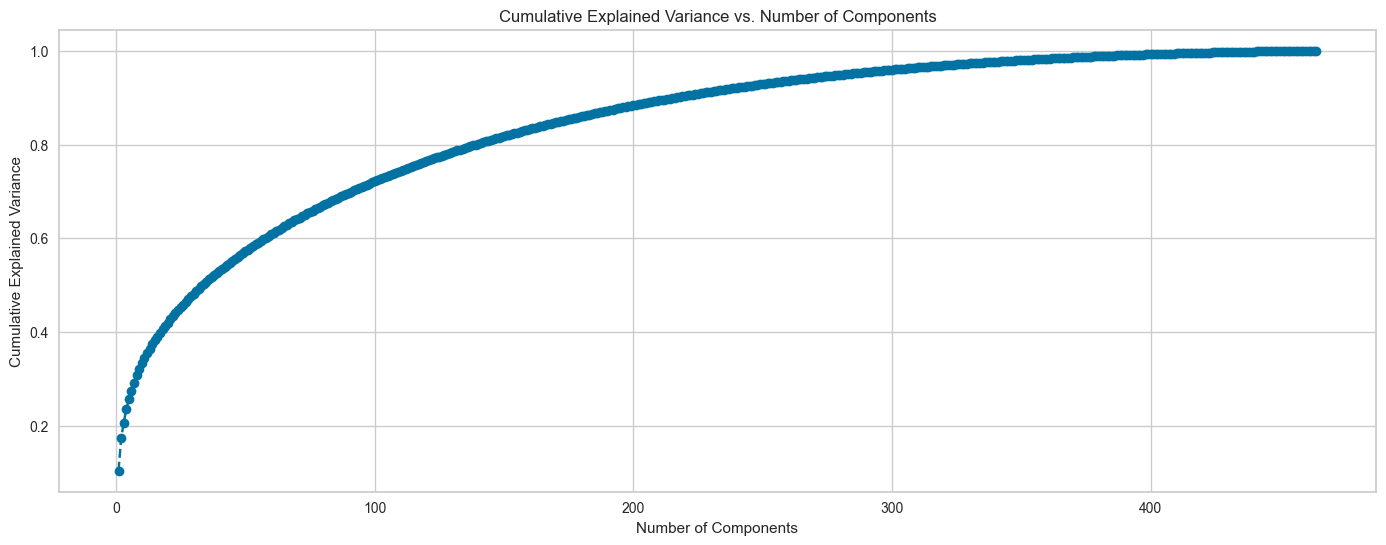

In [89]:
# Standardize the Data improve the robustness and performance of your models 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ret_T)

# PCA Dimensionality Reduction
pca = PCA(random_state=1)
pca.fit(scaled_data)

# Plot explained variance ratio to decide on the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(17, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [90]:
# Check the number of components needed to explain 70% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.7:
        print(str(i) + " components needed to explain 70% of the variance")
        break

# Check the number of components needed to explain 80% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.8:
        print(str(i) + " components needed to explain 80% of the variance")
        break

# Check the number of components needed to explain 90% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.9:
        print(str(i) + " components needed to explain 90% of the variance")
        break

91 components needed to explain 70% of the variance
139 components needed to explain 80% of the variance
216 components needed to explain 90% of the variance


In [91]:
scaled_data

array([[ 1.4697973 , -0.70208171,  1.01334509, ...,  0.71537631,
         0.40365902, -1.14806137],
       [-1.36124918,  0.220219  , -0.59278708, ..., -3.40919807,
         0.3652427 , -0.93164314],
       [-0.45341451,  0.10932016,  0.56167307, ..., -0.29457471,
        -0.54643687, -0.57714428],
       ...,
       [ 1.05082532,  1.11906815,  0.97287165, ...,  0.38310756,
        -0.47258302, -0.6300239 ],
       [-0.529209  ,  0.07608361, -0.51696848, ...,  0.27043255,
        -0.36438557, -0.02008124],
       [-0.09517791,  0.19746094,  0.56739072, ...,  0.96367755,
        -0.6640634 , -0.7263174 ]])

In [92]:
# Choose the number of components based on the plot - Here we chose 80% of varaince explained
n_components = 139

pca = PCA(n_components=n_components, random_state=1)
principal_components = pca.fit_transform(scaled_data)

# principal_components as a dataframe
principal_components = pd.DataFrame(principal_components)

print("Shape of principal_components: " + str(principal_components.shape))
principal_components


Shape of principal_components: (464, 139)


,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,-5.431178,7.877642,1.469237,-2.660372,-3.273634,-0.689827,-1.183670,0.994793,-3.008488,3.801262,...,-0.766850,0.558835,-1.100338,-0.067266,0.017195,-1.447796,-0.457068,0.037362,1.422261,-3.206203
1,24.696439,-3.230677,-22.469717,6.029874,-0.136688,-3.867791,-4.916728,10.575235,-2.340681,-9.515472,...,-1.635833,1.820037,-1.062163,-1.400917,-2.024668,-0.357572,0.357258,-2.282125,-0.032700,-0.277203
2,-5.021283,13.309952,0.081495,1.425013,1.933227,-1.046484,-0.164921,-0.273557,1.445998,-1.875393,...,2.301901,-0.624971,2.082560,1.693104,-1.250713,-0.256371,0.402678,-0.280710,0.086282,1.398208
3,-6.243898,0.175082,6.053474,-2.446508,-3.781298,-3.711812,-1.023596,6.166121,0.820756,2.101797,...,-2.016919,-0.598346,0.536664,0.126553,1.589123,2.389003,-1.484229,2.037167,1.331594,-4.174268
4,-10.193246,4.875089,3.080661,-2.636303,-4.589826,-2.940285,-0.521187,2.840930,-1.487822,3.018016,...,0.559811,-0.478355,0.558175,0.052663,1.189127,0.302339,1.226581,-0.006126,0.200850,0.114251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,-5.882605,-3.120564,-2.281469,1.508789,-1.229218,0.996543,-1.371062,-2.300543,-0.577819,-1.287278,...,-0.827340,0.713643,-0.369976,-1.255646,-0.307499,-0.512697,0.755428,1.382661,-0.501986,-0.300569
460,-2.174514,-0.679356,-1.736072,2.808058,-3.923085,-2.325214,-1.760784,2.798461,-2.412121,4.975276,...,-0.473114,1.306731,0.056758,0.389604,0.575143,1.417083,-3.536229,-0.961360,2.192051,1.709304
461,1.756099,13.628771,0.131216,0.027738,1.015657,3.773782,-2.341278,-1.621518,-1.007630,1.428974,...,-0.182286,-2.885556,-2.200716,-0.844958,-0.251008,1.078492,2.026615,0.265126,1.152086,2.278931
462,17.566294,-7.950418,-2.329597,-7.072708,-5.537879,-3.346729,10.257466,-2.675345,6.340847,0.722367,...,0.291789,0.686191,-0.074971,0.997615,-0.386303,-0.435607,-0.634107,-0.237344,-0.652714,0.210306


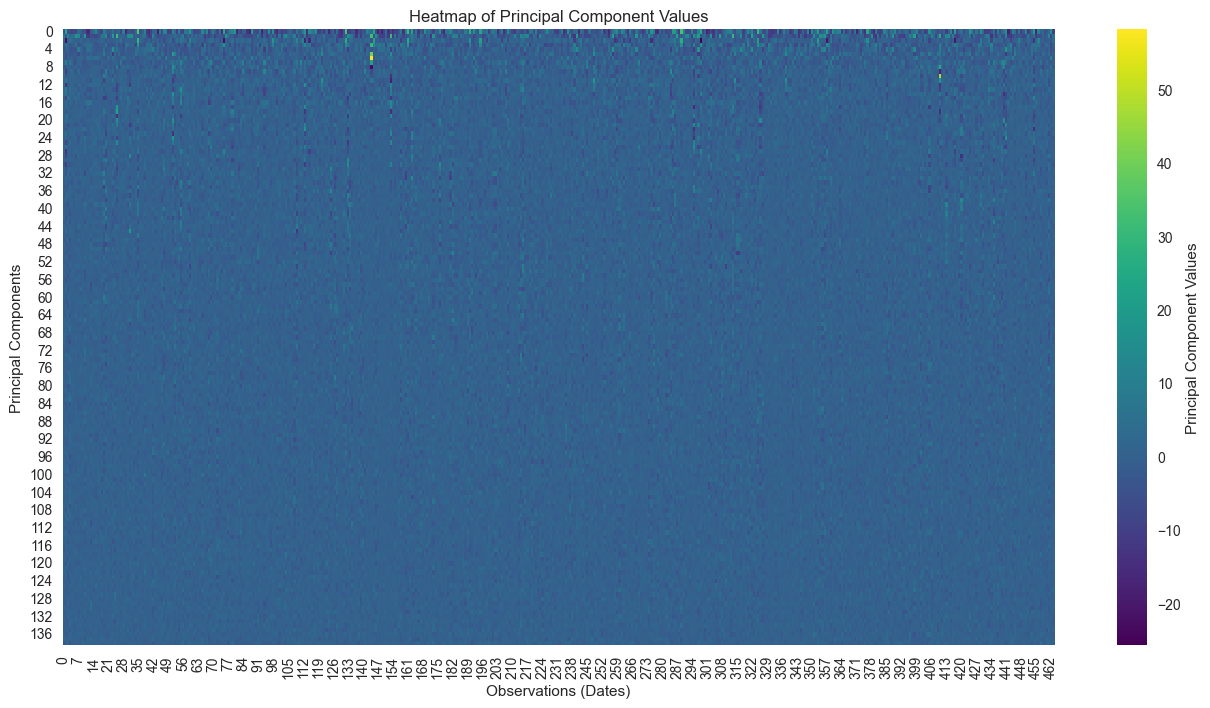

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming principal_components is a DataFrame with 160 columns
# You may need to adjust the column names based on your data``

# Create a heatmap to visualize the values of principal components
plt.figure(figsize=(16, 8))
sns.heatmap(principal_components.T, cmap='viridis', cbar_kws={'label': 'Principal Component Values'})
plt.title('Heatmap of Principal Component Values')
plt.xlabel('Observations (Dates)')
plt.ylabel('Principal Components')
plt.show()

# heatmap due to the number of components not interpretable (or useful) for our analysis

In [94]:
clf = DBSCAN(eps=12, min_samples=5)

clf.fit(principal_components)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

clustered = clf.labels_ 

n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


from sklearn import metrics

print(f"Silhouette Coefficient: {metrics.silhouette_score(principal_components, labels):.3f}")

Estimated number of clusters: 5
Estimated number of noise points: 404
Silhouette Coefficient: -0.181


In [132]:
eps_value = 12
min_samples_value = 5

clf = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clf.fit(principal_components)

# Extract cluster labels and remove noise points
labels = clf.labels_
clustered_mask = (labels != -1)
# print(clustered_mask)
clustered_data = principal_components[clustered_mask]
clustered_labels = labels[clustered_mask]

# Calculate the number of clusters (excluding noise)
n_clusters_ = len(set(clustered_labels))

# Calculate the number of noise points
n_noise_ = len(labels) - len(clustered_data)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Calculate silhouette score for clustered data
silhouette_avg = metrics.silhouette_score(clustered_data, clustered_labels)
print(f"Silhouette Coefficient (excluding noise): {silhouette_avg:.3f}")


# Silhouette Coefficient is already quite good but lets try to improve it by tuning the hyperparameters!


Estimated number of clusters: 5
Estimated number of noise points: 404
Silhouette Coefficient (excluding noise): 0.469


In [133]:
clustered_series = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1)]
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 5
Pairs to evaluate: 2460


In [109]:
# # Finding optimal eps and min_samples values still doesnt work as intended
# # Although we have a negative silhouette score the previous clustering attemped makes more sense (stock wise)
# # By havin a high eps value we are nudging the algorithm to cluster all the stocks in one cluster which is bad


# eps_values = np.arange(10, 100, 2.5)  
# min_samples_values = list(range(5,12))  # We want to test min_samples values starting 3 

# best_eps = None     
# best_min_samples = None
# best_silhouette_score = -1

# # Perform grid search

# for eps in eps_values:
#     for min_samples in min_samples_values:
#         # Fit DBSCAN
#         clf = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = clf.fit_predict(principal_components)
#         unique_labels = set(labels)

#         if len(unique_labels) <= 5: # We want at least 4 clusters
#             print("Error: Insufficient clusters formed.")
#         else:
        
#             # Calculate silhouette score
#             silhouette_avg = metrics.silhouette_score(scaled_data, labels)
            
#             # Update best parameters if silhouette score is higher
#             if silhouette_avg > best_silhouette_score:
#                 best_silhouette_score = silhouette_avg
#                 best_eps = eps
#                 best_min_samples = min_samples

# # Print the best parameters and corresponding silhouette score
# print(f"Best eps: {best_eps}")
# print(f"Best min_samples: {best_min_samples}")
# print(f"Best Silhouette Score: {best_silhouette_score}")

# # Fit DBSCAN with best parameters
# clf = DBSCAN(eps=best_eps, min_samples=best_min_samples)
# clf.fit(principal_components)
# labels = clf.labels_
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# clustered = clf.labels_ 

# n_noise_ = list(labels).count(-1)

# print("Estimated number of clusters: %d" % n_clusters_)
# print("Estimated number of noise points: %d" % n_noise_)


# from sklearn import metrics

# print(f"Silhouette Coefficient: {metrics.silhouette_score(principal_components, labels):.3f}")




Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
E

In [152]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

eps_values = np.arange(5, 50, 0.1)
min_samples_values = list(range(5, 15))  # We want to test min_samples values starting 3

best_eps = None
best_min_samples = None
best_silhouette_score = -1

# Perform grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        # Fit DBSCAN
        clf = DBSCAN(eps=eps, min_samples=min_samples)
        labels = clf.fit_predict(principal_components)
        unique_labels = set(labels)

        if len(unique_labels) <= 4:  # We want at least 4 clusters
            print("Error: Insufficient clusters formed.")
        else:
            # Extract cluster labels and remove noise points
            clustered_mask = (labels != -1)
            clustered_data = principal_components[clustered_mask]
            clustered_labels = labels[clustered_mask]

            # Calculate silhouette score
            silhouette_avg = metrics.silhouette_score(clustered_data, clustered_labels)

            # Update best parameters if silhouette score is higher
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

# Print the best parameters and corresponding silhouette score
print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_silhouette_score}")

# Fit DBSCAN with best parameters
best_clf = DBSCAN(eps=best_eps, min_samples=best_min_samples)

best_labels = best_clf.fit_predict(principal_components)
n_clusters_ = len(set(best_labels)) - (1 if -1 in best_labels else 0)

# This is used to make it unifrom with the previous code (I'll make it more unform later when we submit the code)
clustered = best_clf.labels_


# Extract cluster labels and remove noise points
best_clustered_mask = (best_labels != -1)
best_clustered_data = principal_components[best_clustered_mask]
best_clustered_labels = best_labels[best_clustered_mask]

n_noise_ = list(best_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"Silhouette Coefficient: {best_silhouette_score:.3f}")


Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
Error: Insufficient clusters formed.
E

In [153]:
clustered_series = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1)]
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 4
Pairs to evaluate: 658


Shape of tsne_result: (464, 2)
[[-2.32133985e+00 -2.18507557e+01]
 [-1.26876774e+01  2.80690212e+01]
 [-1.17446432e+01 -2.02916164e+01]
 [ 9.35553741e+00 -1.59443293e+01]
 [-1.40060872e-01 -1.88176861e+01]
 [-6.54275465e+00 -8.57031250e+00]
 [-1.35795774e+01 -1.94308395e+01]
 [-2.24325085e+01 -1.14500332e+01]
 [-4.40111494e+00  1.16761293e+01]
 [-5.47560215e+00 -7.87758255e+00]
 [-1.61295147e+01 -1.67343178e+01]
 [ 2.58055000e+01 -4.52832937e+00]
 [ 2.68161469e+01 -5.69487238e+00]
 [ 2.74073620e+01 -8.13684147e-03]
 [-4.93603992e+00  1.57644358e+01]
 [-4.97047853e+00  1.88607979e+01]
 [-3.59251189e+00  1.45426435e+01]
 [-2.45173788e+00 -4.60090208e+00]
 [-7.90113974e+00 -1.60684357e+01]
 [-1.60306244e+01  1.23535738e+01]
 [-5.96179295e+00 -1.83410778e+01]
 [-2.90475893e+00  1.36427364e+01]
 [-9.36392975e+00  3.13851523e+00]
 [-2.67216282e+01 -1.07594328e+01]
 [-2.50475669e+00 -2.49418858e-02]
 [-2.01594543e+01 -1.69299755e+01]
 [-1.08715582e+01  3.54298902e+00]
 [ 7.98830557e+00 -1.683

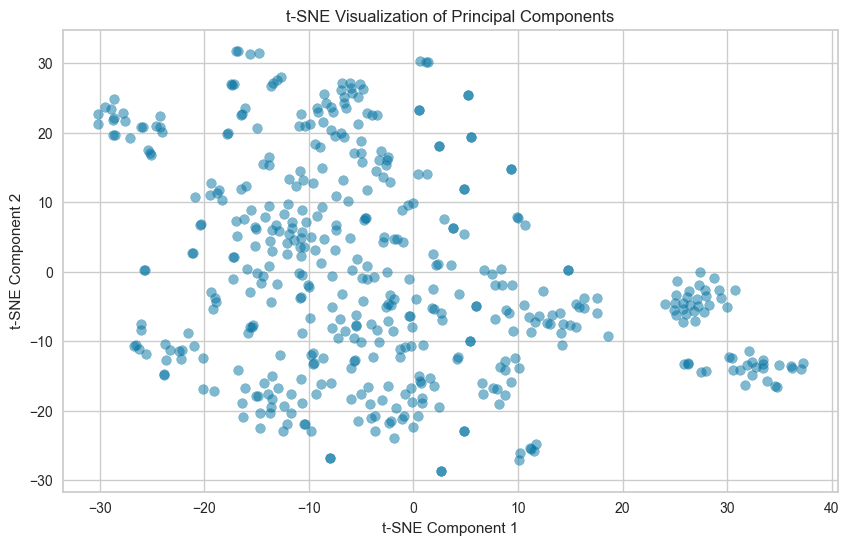

In [154]:
# Initialize t-SNE with 2 components for 2D visualization
tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1)

# Fit and transform the principal components
tsne_result = tsne.fit_transform(principal_components)
print("Shape of tsne_result: " + str(tsne_result.shape))
print(tsne_result)

# Create a scatter plot of the t-SNE result
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Principal Components')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

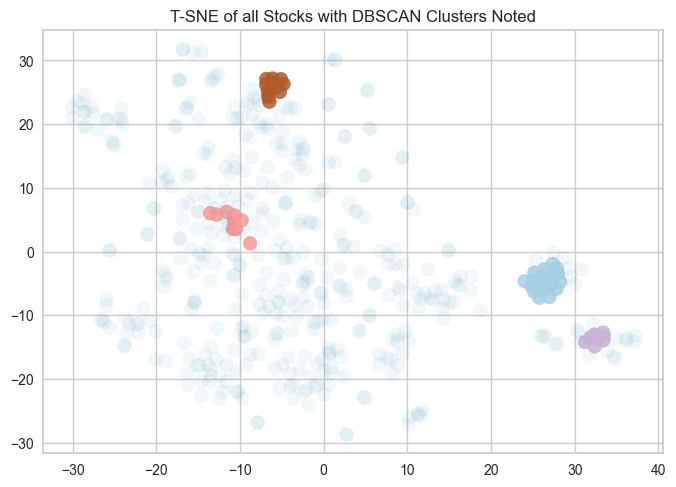

In [157]:
plt.figure(1, facecolor='white')
plt.clf()

plt.scatter(
    tsne_result[(clustered!=-1), 0],
    tsne_result[(clustered!=-1), 1],
    s=100,
    alpha=0.85,
    c=clustered[clustered!=-1],
    cmap=cm.Paired
)

plt.scatter(
    tsne_result[(clustered_series_all==-1).values, 0],
    tsne_result[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted')

plt.show()

In [151]:
# range_n_clusters = [2,3,4,5,6]

# for n_clusters in range_n_clusters:
#     # Create a subplot with 1 row and 2 columns
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(18, 7)

#     # The 1st subplot is the silhouette plot
#     # The silhouette coefficient can range from -1, 1 
#     ax1.set_xlim([-0.1, 1])
#     # The (n_clusters+1)*10 is for inserting blank space between silhouette
#     # plots of individual clusters, to demarcate them clearly.
#     ax1.set_ylim([0, len(tsne_result) + (n_clusters + 1) * 10])

#     # Initialize the clusterer with n_clusters value and a random generator
#     # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     cluster_labels = clusterer.fit_predict(tsne_result)

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed
#     # clusters
#     silhouette_avg = metrics.silhouette_score(tsne_result, cluster_labels)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)

#     # Compute the silhouette scores for each sample
#     sample_silhouette_values = metrics.silhouette_samples(tsne_result, cluster_labels)

#     y_lower = 10
#     for i in range(n_clusters):
#         # Aggregate the silhouette scores for samples belonging to
#         # cluster i, and sort them
#         ith_cluster_silhouette_values = \
#             sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
#         ax1.fill_betweenx(np.arange(y_lower, y_upper),
#                           0, ith_cluster_silhouette_values,
#                           facecolor=color, edgecolor=color, alpha=0.7)

#         # Label the silhouette plots with their cluster numbers at the middle
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         # Compute the new y_lower for next plot
#         y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("The silhouette plot for the various clusters.")
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     # The vertical line for average silhouette score of all the values
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(tsne_result[:, 0], tsne_result[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

#     plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
#                   "with n_clusters = %d" % n_clusters),
#                  fontsize=14, fontweight='bold')

# plt.show()

In [149]:
# print out the stock names that are in each cluster
for i in range(len(ticker_count_reduced)):
    print("Cluster " + str(i+1) + " (" + str(len(clustered_series[clustered_series==i])) + " stocks)")
    for name in clustered_series[clustered_series==i].index:
        print(companies_dict[name], end=", ")
    print("\n")
    # print(clustered_series[clustered_series==i].index.tolist())
    # print(", ".join(clustered_series[clustered_series==i].index.tolist()))
    # print()


Cluster 1 (21 stocks)
Ameren, American Electric Power, Atmos Energy, American Water Works, CMS Energy, Dominion Energy, DTE Energy, Duke Energy, Consolidated Edison, Eversource, Entergy, Evergy, Exelon, Alliant Energy, NextEra Energy, NiSource, Public Service Enterprise Group, Pinnacle West, Southern Company, WEC Energy Group, Xcel Energy, 

Cluster 2 (9 stocks)
Ametek, Dover Corporation, Emerson Electric, Eaton Corporation, Fortive, Honeywell, IDEX Corporation, Illinois Tool Works, Roper Technologies, 

Cluster 3 (8 stocks)
Alexandria Real Estate Equities, AvalonBay Communities, Camden Property Trust, Equity Residential, Essex Property Trust, Mid-America Apartment Communities, Realty Income, UDR, Inc., 

Cluster 4 (11 stocks)
Citizens Financial Group, Comerica, Fifth Third Bank, Huntington Bancshares, KeyCorp, M&T Bank, PNC Financial Services, Regions Financial Corporation, Truist, U.S. Bank, Zions Bancorporation, 



In [102]:
# To evaluate the performance of the clusters, we will use the Sharpe Ratio
# from sklearn.metrics import silhouette_score
# silhouette_avg = silhouette_score(ret_T, labels)
# print("The average silhouette_score is :", silhouette_avg)

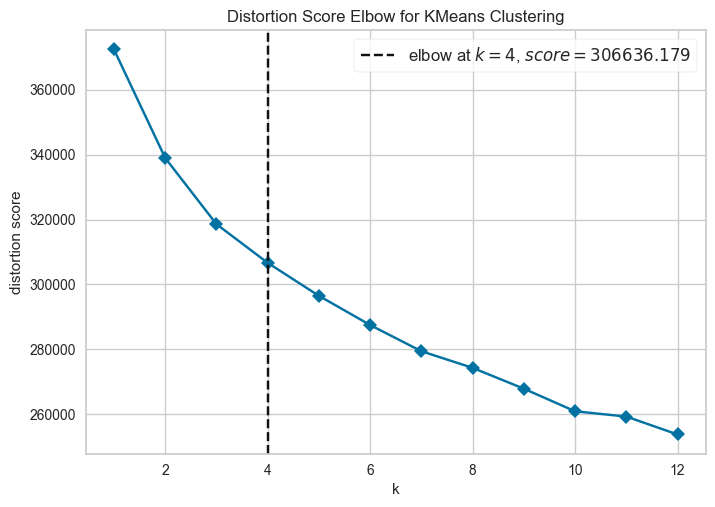

In [103]:
# As a contrast we also want to use KMeans to cluster the stocks



# Create k-Means model and find optimal number of clusters with the elbow method

model = KMeans(random_state = 1)
visualizer = KElbowVisualizer(
    model, k=(1,13), timings=False, random_state = 1
)

visualizer.fit(principal_components)        
visualizer.show()
n_clusters = visualizer.elbow_value_

kmeans = KMeans(n_clusters=n_clusters, random_state=1)
cluster_assignments = kmeans.fit_predict(principal_components)

In [104]:
# Add the cluster assignments to a copy of the returns dataframe

returns_clustered = ret_T.copy()
returns_clustered['Cluster'] = cluster_assignments

# Explore Clusters
# Explore the clusters to identify potential pairs

for cluster_id in range(n_clusters):
    cluster_stocks = returns_clustered[returns_clustered['Cluster'] == cluster_id].drop(columns=['Cluster'])
    mean_returns = cluster_stocks.mean(axis=1)
    print(f'\nCluster {cluster_id + 1}' + " (" + str(mean_returns.count()) + " stocks)")
    # print(f'Total Mean Return: {mean_returns.mean()}')
    for name, value in mean_returns.items():
        print(companies_dict[name])



Cluster 1 (196 stocks)
AbbVie
Abbott
Accenture
Archer-Daniels-Midland
Automated Data Processing
Aflac
Assurant
Arthur J. Gallagher & Co.
Allstate
Allegion
Amcor
Ametek
Amgen
Aon
A. O. Smith
Air Products and Chemicals
Amphenol
Avery Dennison
AutoZone
Baxter International
Best Buy
Becton Dickinson
Biogen
Booking Holdings
BlackRock
Bristol Myers Squibb
Broadridge Financial Solutions
Brown & Brown
Boston Scientific
Cardinal Health
Chubb Limited
CBRE Group
CDW
CH Robinson
Charter Communications
Cigna
Cincinnati Financial
Comcast
CME Group
Cummins
Centene Corporation
CooperCompanies
Costco
Copart
Cisco
CSX
Cintas
Cognizant
CVS Health
John Deere
Dollar General
Quest Diagnostics
DR Horton
Danaher Corporation
Walt Disney
Dollar Tree
Dover Corporation
Domino's
Darden Restaurants
DaVita Inc.
Ecolab
Equifax
Estée Lauder Companies (The)
Elevance Health
Emerson Electric
Eaton Corporation
Expeditors International
Fastenal
FactSet
FedEx
F5, Inc.
Fidelity National Information Services
Fleetcor
FMC Cor

In [105]:
n_clusters 

4

In [106]:
# Create and fit the model with the optimal number of clusters from above
model = KMeans(n_clusters = n_clusters)
model.fit(ret_T)

labels = model.predict(ret_T)

# create a DataFrame aligning labels & companies
clusters = pd.DataFrame({'cluster': labels, 'ticker': returns_1_day.columns})

for i in clusters.index:
    clusters.loc[i,"company"] = companies_dict[clusters.loc[i,"ticker"]]

# display df sorted by cluster labels. Would you say that the clustering makes sense?
clusters.sort_values('cluster').reset_index(drop=True)
# clusters.to_csv('clusters.csv')

,cluster,ticker,company
0,0,CZR,Caesars Entertainment
1,0,SPG,Simon Property Group
2,0,APA,APA Corporation
3,0,SLB,Schlumberger
4,0,DAL,Delta Air Lines
...,...,...,...
459,3,PNC,PNC Financial Services
460,3,PNR,Pentair
461,3,IPG,Interpublic Group of Companies (The)
462,3,APTV,Aptiv


In [107]:
# Explore the clusters to identify potential pairs

for cluster_id in range(n_clusters):
    cluster_stocks = ret_T[ret_T.index.isin(clusters[clusters['cluster']==cluster_id]['ticker'])]
    mean_returns = cluster_stocks.mean(axis=1)
    volatility = cluster_stocks.std(axis=1)
    print(f'\nCluster {cluster_id + 1} Mean Returns:')
    print(f'Total Mean Return: {mean_returns.mean()}')
    print(f'Mean Volatility: {volatility.mean()}')
    print(f'Size: {mean_returns.count()} Stocks')
    print(mean_returns.sort_values(ascending=False).head())


Cluster 1 Mean Returns:
Total Mean Return: 0.0004998752604163709
Mean Volatility: 0.035758143430161766
Size: 28 Stocks
stock
CZR    0.002211
HES    0.001063
MGM    0.000971
DVN    0.000966
MOS    0.000946
dtype: float64

Cluster 2 Mean Returns:
Total Mean Return: 0.0007272455135012397
Mean Volatility: 0.01797786737623064
Size: 192 Stocks
stock
MOH     0.001728
WST     0.001721
POOL    0.001691
TGT     0.001508
LLY     0.001439
dtype: float64

Cluster 3 Mean Returns:
Total Mean Return: 0.0014965153226277506
Mean Volatility: 0.02420121155719972
Size: 79 Stocks
stock
ENPH    0.005562
TSLA    0.003623
AMD     0.003165
ETSY    0.003050
DXCM    0.002670
dtype: float64

Cluster 4 Mean Returns:
Total Mean Return: 0.0006579492278907616
Mean Volatility: 0.02365532879601826
Size: 165 Stocks
stock
LYV    0.001459
HCA    0.001372
FCX    0.001347
TT     0.001312
PWR    0.001309
dtype: float64


In [108]:
clusters.groupby("cluster").count()

,ticker,company
cluster,,
0,28,28
1,192,192
2,79,79
3,165,165


We see the problem with KMeans clustering. It will always find clusters, even if the data doesn't have any clusters. In this case, we see that the clusters are not very meaningful. We can see that some of the stocks in each cluster are not very similar to each other. 